Introduction
---

In this notebook we are going to implement a code in order to compute the equation of motion of many charged particles inside an electromagnetic wave. This equation is going to have the features to resonate with certain particles. It is our task to determine the conditions that are going to be satisfied to resonate with the wave.

Construction of the numerical tool
---

In [1]:
### iMPORTING ALL LIBRARIES THAT ARE GOING TO BE USEFULL

import numpy as np
from tkinter import N
from tqdm import tqdm
from scipy.io import loadmat,savemat
import matplotlib.pyplot as plt
from Particles_class import particles, particles_resembled
from Pusher_class import Boris_pusher
from scipy.constants import mu_0,epsilon_0,m_e,m_p,e,pi,c
from threading import Thread

C:\Users\Pacopol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
### A CLASS FOR PARTICLESS. FEATURES TO PLOT AND TO RESAMBLE N PARTICLES CLASS IN 1 (NEEDED WHEN WE START THREADING)
class particles():
  def __init__(self, x0, v0, m,q):
    # Axis notation 0 = particles, 1 = space x y z, 2 = time
    self.x = x0[:,:,np.newaxis]
    self.v = v0[:,:,np.newaxis]
    self.m = m
    self.q = q
    self.firstx = True
    self.firstv = True
    self.dt = []

  def x_forward(self, dt):
    # It computes the position of each particle.
    if self.firstx:
      self.firstx = False
      self.x = np.concatenate(
        (self.x,
         self.x[:, :, -1][:, :, np.newaxis] + self.v[:, :, -1][:, :, np.newaxis] * dt * 0.5),
        axis=2)
      self.dt = dt
    else:
        self.x = np.concatenate((self.x, self.x[:, :, -1][:, :, np.newaxis] +
                                 self.v[:, :, -1][:, :, np.newaxis] * self.dt),
                                axis=2)
  def v_forward(self, v_new):
    self.v = np.concatenate((self.v, v_new[:, :, np.newaxis]), axis=2)

  def get_last_step(self):
    return self.m,self.q,self.x[:,:,-1],self.v[:,:,-1]

  def get_mean_energy_in_time(self):
    return 0.5*self.m*np.mean(np.linalg.norm(self.v,axis = 1)**2,axis = 0)/e

  def t(self):
    return np.arange(0,self.x.shape[2],1)*self.dt

  def plot_trajectory(self,colord = 'b'):
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    for k in range(self.x.shape[0]):
        ax.plot3D(self.x[k,0,:],self.x[k,1,:],self.x[k,2,:],colord,alpha = 0.5)
    ax.set_xlabel('x    (m)',size = 13)
    ax.set_ylabel('y    (m)',size = 13)
    ax.set_zlabel('z    (m)',size = 13)
    ax.set_title('Particles trajectories')
    return fig
  def mean_Vx(self):
    return np.sum(self.v[:,0,:],axis = 1)/self.t().shape[0]
  def mu(self):
    return np.sum(self.v[:,0,:] / np.linalg.norm(self.v,axis = 1),axis = 1)/self.t().shape[0]
  def dmu2(self):
    return np.sum((self.v[:,0,:] / np.linalg.norm(self.v,axis = 1)-self.mu()[:,np.newaxis])**2 , axis = 1)/self.t().shape[0]
  def plot_dmu2_Vx(self):
    fig = plt.figure()
    plt.plot(self.mean_Vx(),self.dmu2(),'.r')
    plt.title(r'$\langle\delta\mu\delta\mu\rangle(\langle V_{e\parallel}\rangle)$')
    plt.yscale('log')
    plt.ylabel(r'$\langle \delta\mu\delta\mu\rangle/V_A^2$ ',size = 13)
    plt.xlabel(r'$\langle V_{e\parallel}\rangle/V_A$')
    plt.grid(b=True, which='major', color='k',alpha = 0.6,linestyle = '-',linewidth = 1);
    plt.minorticks_on()
    plt.grid(b=True, which='minor', color='b',alpha = 0.4,linestyle = '--',linewidth = 0.7);
  def plot_energy_in_time(self,timescale,name_timescale,colord = 'b',axis = None):
    fig = plt.figure()
    plt.plot(self.t()/timescale,self.get_mean_energy_in_time())
    plt.title('Energy in time')
    plt.ylabel(r'$\langle E\rangle$  (eV)',size = 13)
    plt.xlabel(r't   ($%s$)'%(name_timescale))
    plt.axis(axis)
    plt.grid()
  def save(self,name):
    savemat(name,{'v':self.v,'x':self.x,'t':self.t})


class particles_resembled(particles):
  def __init__(self,list_of_particles_classes):
    for i,particles in enumerate(list_of_particles_classes):
      if i == 0:
        self.v = particles.v
        self.x = particles.x
        size = self.x.shape[2]
        self.q = particles.q
        self.m = particles.m
        self.dt = particles.dt
      else:
        if particles.q != self.q or particles.m != self.m or self.dt != particles.dt:
          TypeError('Particles has not the same q m dt properties.')
        else:
          self.v = np.concatenate((self.v,particles.v),axis = 0)
          self.x = np.concatenate((self.x,particles.x),axis = 0)

In [3]:
### A CLASS FOR THE E AND B FIELDS, PREPARED IN CASE THAT WE WANT GIVE A NON ANALYTICAL FIELD BUT A DISCRETE ONE.

class fields():
    def __init__(self, E, B, mode='Analytical'):
        if mode == 'Analytical':
            self.E = E
            self.B = B
            self.mode = mode
        elif mode == 'Numerical':
            print('Not programmed module')
            self.mode = mode
            TypeError()
    def get_fields_analytical(self, x, t):
        E_mat = np.zeros(x.shape)
        B_mat = np.zeros(x.shape)
        for k in range(x.shape[0]):
            E_mat[k,:]=self.E(x[k,:],t)
            B_mat[k,:]=self.B(x[k,:],t)
        return E_mat,B_mat
    def get_fields_numerical():
        print('Not programmed module')
        raise TypeError()

In [4]:
### CLASS RESAMBLING ALL CLASSES AND SIMULATING THE SYSTEM USING THE BORIS METHOD.

class Boris_pusher():
    
    def __init__(self, particles, dt, E, B, mode = 'Analytical'):
        self.particles = particles
        self.dt = dt
        self.fields = fields(E, B, mode=mode)
        self.k = 0

    def forward(self):
        dt = self.dt
        t_ = self.k*dt
        self.particles.x_forward(dt)
        m, q, x, v = self.particles.get_last_step()
        E, B = self.fields.get_fields_analytical(x, t_)
        v_minus = v + q / m * E * dt / 2
        t = q * dt / 2 / m * B
        v_prime = v_minus + np.cross(v_minus, t,axis = 1)
        s = t * 2 / (1 + np.linalg.norm(t, axis = 0)**2)
        v_plus = v_minus + np.cross(v_prime, s,axis = 1)
        v_new = v_plus + q * E / m * dt / 2
        self.particles.v_forward(v_new)
        self.k += 1

    def simulate(self,N):
        for k in tqdm(range(N)):
            self.forward()

    def forward_opt(self,xold,vold,t):
        dt = self.dt
        m = self.particles.m
        q = self.particles.q
        E, B = self.fields.get_fields_analytical(xold, t)
        v_minus = vold + q / m * E * dt / 2
        t_ = q * dt / 2 / m * B
        v_prime = v_minus + np.cross(v_minus, t_,axis = 1)
        s = t_ * 2 / (1 + np.linalg.norm(t_, axis = 1)[:,np.newaxis]**2)
        v_plus = v_minus + np.cross(v_prime, s,axis = 1)
        v_new = v_plus + q * E / m * dt / 2
        return v_new

    def simulate_opt(self,N):
        if self.particles.firstx:
            TypeError('Simulation already started with no optimization. If you want to use this mode you need to do the first step with simulate_opt.')
        self.particles.firstx,self.particles.firstv = False,False
        xold = self.particles.x[:,:,0]
        vold = self.particles.v[:,:,0]
        x = np.zeros([xold.shape[0],xold.shape[1],N])
        v = np.zeros([vold.shape[0],vold.shape[1],N])
        x[:,:,0],v[:,:,0] = xold,vold
        x[:,:,1]=xold+vold*self.dt*0.5
        v[:,:,1] = self.forward_opt(xold,vold,0)
        del xold,vold
        for k in tqdm(range(1,N-1)):
            x[:,:,k+1] = x[:,:,k]+v[:,:,k]*self.dt
            v[:,:,k+1] = self.forward_opt(x[:,:,k],v[:,:,k],k*self.dt)
        self.particles.x = x
        self.particles.v = v
        self.particles.dt = self.dt

Numerical simulation
---

Now that we have all the code done, we need only to use the classes in order to simulate the system. Lets Write a little code to see the $\textbf{\underline{conservation of energy}}$.

In [5]:
B0 = 1
E0 = 100

wc_e = e*B0/(m_e)
wc_p = e*B0/(m_p)

Ncores = 1
Npart_eachcore = 20
electrons = []
protons = []
for k in range(Ncores):
    x0, v0 =1e-6*np.random.rand(Npart_eachcore,3), (np.random.rand(Npart_eachcore,3)-0.5 * np.ones([Npart_eachcore,3]))*1e6
    electrons.append(particles(x0*1e-3, v0, m_e, -e))
for k in range(Ncores):
    x0, v0 =1e-6*np.random.rand(Npart_eachcore,3), (np.random.rand(Npart_eachcore,3)-0.5 * np.ones([Npart_eachcore,3]))*1e6
    protons.append(particles(x0, v0, m_p, e))



E = lambda x,t : np.array([0,E0,0])
B = lambda x,t : np.array([0,0,B0])

dt_e = 1*wc_e**-1
dt_p = 1*wc_p**-1

test_electrons_pusher = []
for k in range(Ncores):
    test_electrons_pusher.append(Boris_pusher(electrons[k],dt_e,E,B,mode = 'Analytical'))
test_protons_pusher = []
for k in range(Ncores):
    test_protons_pusher.append(Boris_pusher(protons[k],dt_p,E,B,mode = 'Analytical'))

N= 100000

print('\nSimulation of test electrons\n %i Thread(s)\n %i Steps of time so %f cyclotrons periods time simulation\n %i Particles per thread\n'%(Ncores,N,N*dt_e*wc_e*2*pi,Npart_eachcore))
th_el = []
for k in range(Ncores):
    th_el.append(Thread(target = test_electrons_pusher[k].simulate_opt, args = (N,)))
for thread in th_el:
    thread.start()
for thread in th_el:
    thread.join()

print('\nSimulation of test protons\n %i Thread(s)\n %i Steps of time so %f cyclotrons periods time simulation\n %i Particles per thread\n'%(Ncores,N,N*dt_p*wc_p*2*pi,Npart_eachcore))
th_pt = []
for k in range(Ncores):
    th_pt.append(Thread(target = test_protons_pusher[k].simulate_opt, args = (N,)))
for thread in th_pt:
    thread.start()
for thread in th_pt:
    thread.join()

electrons_ = particles_resembled(electrons)
protons_ = particles_resembled(protons)




Simulation of test electrons
 1 Thread(s)
 100000 Steps of time so 628318.530718 cyclotrons periods time simulation
 20 Particles per thread



100%|██████████| 99998/99998 [00:21<00:00, 4755.00it/s]



Simulation of test protons
 1 Thread(s)
 100000 Steps of time so 628318.530718 cyclotrons periods time simulation
 20 Particles per thread



100%|██████████| 99998/99998 [00:20<00:00, 4959.74it/s]


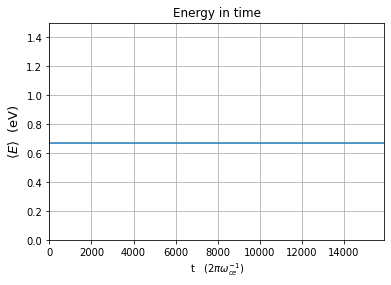

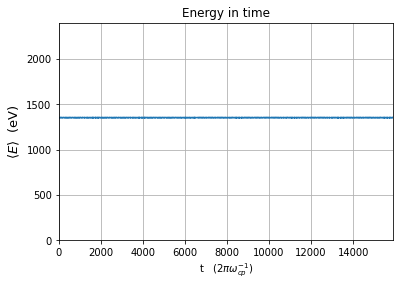

In [6]:
#electrons_.plot_trajectory()
#protons_.plot_trajectory()
electrons_.plot_energy_in_time(wc_e**-1*2*pi,'2\pi\omega_{ce}^{-1}',axis = [0,N*dt_e*wc_e/(2*np.pi),0,1.5])
protons_.plot_energy_in_time(wc_p**-1*2*pi,'2\pi\omega_{cp}^{-1}',axis = [0,N*dt_e*wc_e/(2*np.pi),0,2400])
plt.show()

Now that we see how the boris pusher conserves extremely well the energy (when it has to be conserved for sure) let us see how the electrons can resonate under a whistler wave. We are going to be inspired in the paper of T. Terasawa, S. Matsukiyo in order to introduce a wave with the good features to resonate with electrons. See https://doi.org/10.48550/arXiv.1211.2852. The conditions shown in the paper are $|\bm B_{wave}|/B_0=10^{-4}$, $\omega = 5\Omega_{ci}$ and $\bm k = 2.44\Omega_{ci}/V_A(\cos\theta,0\sin\theta)$. With the predominant magnetic field $\bm B_0\parallel \bm e_x$. In our code, we normalize to the magnetic field and the Alfvén speed.



Parallel wave $\theta = 0$
---

In [7]:
#Normalization to B0
B0 = [-1,0,0]
E0 = [0,0,0]

norm_B0 = np.linalg.norm(B0)
wc_e = e*norm_B0/(m_e)
wc_p = e*norm_B0/(m_p)

## Normalizing in function to Alfven velocity
V_A = 1

## Perturbation definition
w_wisteler = 5*wc_p
theta = 0               ## Changing paramether to change resonance condition.
k0 = 2.044*wc_p/V_A
K_ = k0*np.array([np.cos(theta),0,np.sin(theta)])


B_wav = lambda x,t : np.linalg.norm(B0)*1e-4*np.array([0,np.cos(w_wisteler*t+np.dot(K_,x)),np.sin(w_wisteler*t+np.dot(K_,x))])
E_wav = lambda x,t : np.linalg.norm(B0)*1e-4*np.array([0,-np.sin(w_wisteler*t+np.dot(K_,x)),np.cos(w_wisteler*t+np.dot(K_,x))])/c





In [8]:
Ncores = 1              # Number of threads
Npart_eachcore = 5000   # Number of particles per thread
N = 1500                # Number of time steps

## Creating list of classes to thread it
electrons = []
for k in range(Ncores):
    x0, v0 = 1e-6*np.random.rand(Npart_eachcore,3), 2*(np.random.rand(Npart_eachcore,3)-0.5 * np.ones([Npart_eachcore,3]))*6000
    electrons.append(particles(x0*1e-3, v0, m_e, -e))
## Define E,B fields
E = lambda x,t : np.array(E0) + E_wav(x,t)
B = lambda x,t : np.array(B0) + B_wav(x,t)
dt_e = 0.1*wc_e**-1

# List of particles to thread
test_electrons_pusher = []
for k in range(Ncores):
    test_electrons_pusher.append(Boris_pusher(electrons[k],dt_e,E,B,mode = 'Analytical'))

print('\nSimulation of test electrons\n %i Threads\n %i Steps of time so %1.0f cyclotrons periods time simulation\n %i Particles per thread (%i particles in total) \n'%(Ncores,N,N*dt_e*wc_e*2*pi,Npart_eachcore,Ncores*Npart_eachcore))
th_el = []
for k in range(Ncores):
    th_el.append(Thread(target = test_electrons_pusher[k].simulate_opt, args = (N,)))
for thread in th_el:
    thread.start()
for thread in th_el:
    thread.join()

electrons_ = particles_resembled(electrons)


Simulation of test electrons
 1 Threads
 1500 Steps of time so 942 cyclotrons periods time simulation
 5000 Particles per thread (5000 particles in total) 



100%|██████████| 1498/1498 [04:40<00:00,  5.33it/s]


[-892.7916607]


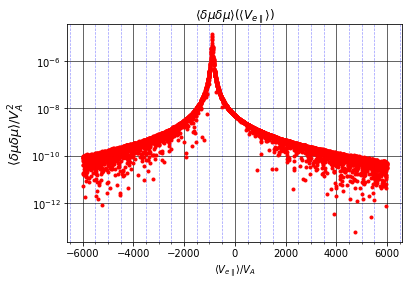

In [9]:
electrons_.plot_dmu2_Vx()
most_res_part = np.where(electrons_.dmu2() == np.max(electrons_.dmu2()))
print(electrons_.mean_Vx()[most_res_part])

In [10]:
### THEORETICAL <U_ex> RESONANT
V_res = (-wc_e+w_wisteler)/K_[0]
print('Theoretical resonant velocity = %f'%(V_res))

Theoretical resonant velocity = -895.867257


In [11]:
Npart = 1               # Number of particles per thread
N = 1000                # Number of time steps

## Creating list of classes to thread it

x0, v0 = np.array([[0,0,0],[0,0,0]]), np.array([[900,3,0],[-900,3,0]])
electrons = particles(x0,v0, m_e, -e)
## Define E,B fields
E = lambda x,t : np.array(E0) + E_wav(x,t)
B = lambda x,t : np.array(B0) + B_wav(x,t)
dt_e = 0.1*wc_e**-1

integrator = Boris_pusher(electrons,dt_e,E,B,mode = 'Analytical')
print('\nSimulation of test electrons\n\n %i Steps of time so %1.0f cyclotrons periods time simulation\n %i Particles\n'%(N,N*dt_e*wc_e*2*pi,Npart))

integrator.simulate_opt(N)



Simulation of test electrons

 1000 Steps of time so 628 cyclotrons periods time simulation
 1 Particles



100%|██████████| 998/998 [00:00<00:00, 4331.64it/s]


(-9.5, 9.5, -9.5, 9.5)

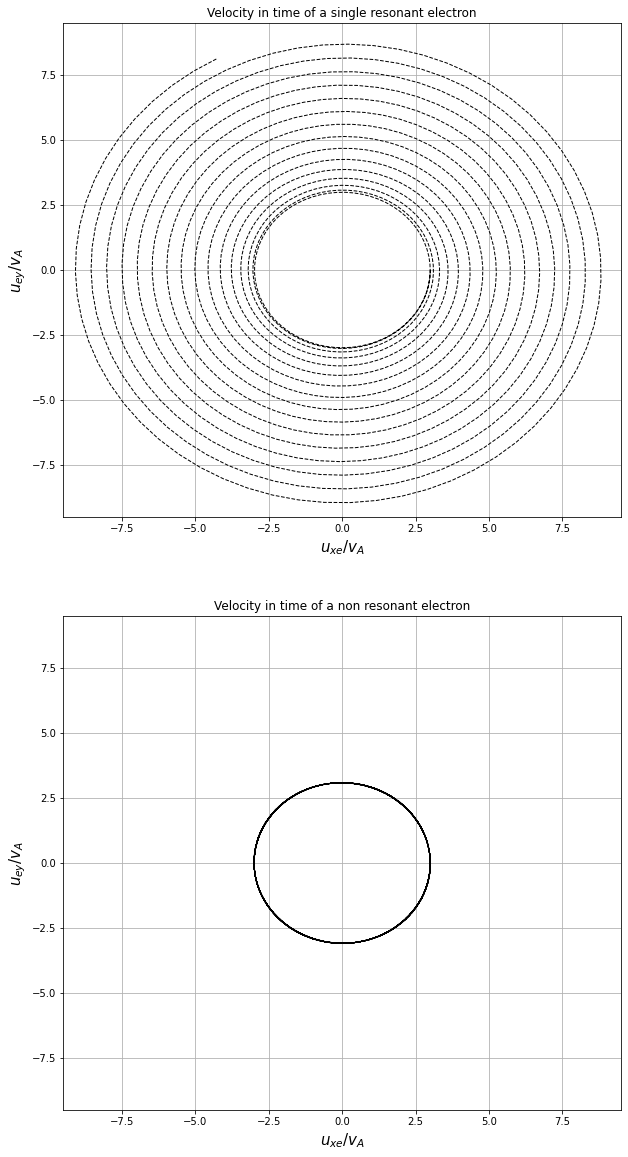

In [12]:
### ANALYSIS OF THE n=+1 RESONANCE MODE
x = electrons.x
v = electrons.v
v1 = v[0,:,:]
x1 = x[0,:,:]
v2 = v[1,:,:]
x2 = x[1,:,:]
fig,ax = plt.subplots(2,figsize = (10,20))
ax[0].plot(v2[1],v2[2],'k--',linewidth = 1)
ax[0].set_title('Velocity in time of a single resonant electron')
ax[0].grid()
ax[0].set_xlabel('$u_{xe}/v_A$',size = 15)
ax[0].set_ylabel('$u_{ey}/v_A$',size = 15)
ax[0].axis([-9.5,9.5,-9.5,9.5])
ax[1].plot(v1[1],v1[2],'k--',linewidth = 1)
ax[1].set_title('Velocity in time of a non resonant electron')
ax[1].grid()
ax[1].set_xlabel('$u_{xe}/v_A$',size = 15)
ax[1].set_ylabel('$u_{ey}/v_A$',size = 15)
ax[1].axis([-9.5,9.5,-9.5,9.5])


Simulation of test electrons

 100000 Steps of time so 62832 cyclotrons periods time simulation
 1 Particles



100%|██████████| 99998/99998 [00:22<00:00, 4524.98it/s]


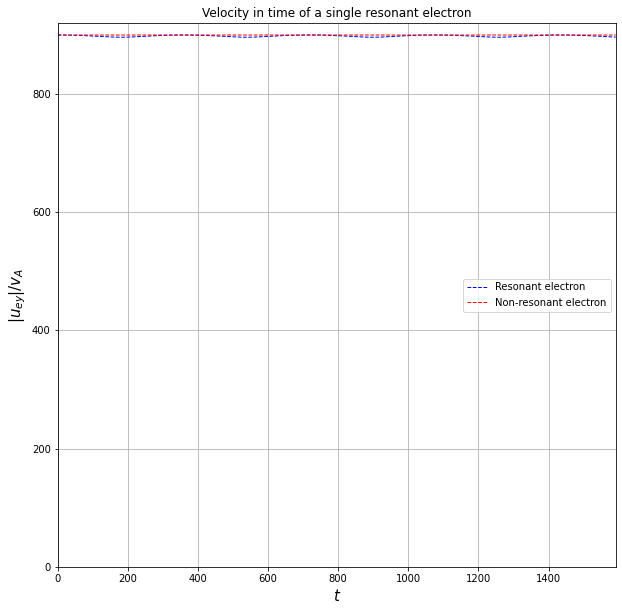

In [13]:
### It is exactly the same simulation than before but more time. I leave this figure here to let Mt. Ciardi see how in fact there is no acceleration in the x direction, only a little oscillation.


Npart = 1               # Number of particles per thread
N = 100000                # Number of time steps

## Creating list of classes to thread it

x0, v0 = np.array([[0,0,0],[0,0,0]]), np.array([[900,3,0],[-900,3,0]])
electrons = particles(x0,v0, m_e, -e)
## Define E,B fields
E = lambda x,t : np.array(E0) + E_wav(x,t)
B = lambda x,t : np.array(B0) + B_wav(x,t)
dt_e = 0.1*wc_e**-1

integrator = Boris_pusher(electrons,dt_e,E,B,mode = 'Analytical')
print('\nSimulation of test electrons\n\n %i Steps of time so %1.0f cyclotrons periods time simulation\n %i Particles\n'%(N,N*dt_e*wc_e*2*pi,Npart))

integrator.simulate_opt(N)

x = electrons.x
v = electrons.v
v1 = v[0,:,:]
x1 = x[0,:,:]
v2 = v[1,:,:]
x2 = x[1,:,:]

t = np.arange(N)*dt_e*wc_e/2/np.pi
fig = plt.figure(figsize = (10,10))
plt.plot(t,np.abs(v2[0]),'b--',linewidth = 1,label = 'Resonant electron')
plt.title('Velocity in time of a single resonant electron')
plt.grid()
plt.xlabel('$t$',size = 15)
plt.ylabel('$|u_{ey}|/v_A$',size = 15)
plt.plot(t,np.abs(v1[0]),'r--',linewidth = 1,label = 'Non-resonant electron')
plt.axis([0,t[-1],0,920])
plt.legend(loc = 'center right')


In [14]:
Ncores = 1              # Number of threads
Npart_eachcore = 2000   # Number of particles per thread
N = 2000                # Number of time steps

## Creating list of classes to thread it
protons = []
for k in range(Ncores):
    x0, v0 = 1e-6*np.random.rand(Npart_eachcore,3), 2*(np.random.rand(Npart_eachcore,3)-0.5 * np.ones([Npart_eachcore,3]))*6000
    protons.append(particles(x0, v0, m_p, e))
## Defining E,B fields.
E = lambda x,t : np.array(E0) + E_wav(-x,0.01*t)
B = lambda x,t : np.array(B0) + B_wav(-x,0.01*t)
dt_p = 0.1*wc_p**-1

# List of particles to thread
test_protons_pusher = []
for k in range(Ncores):
    test_protons_pusher.append(Boris_pusher(protons[k],dt_p,E,B,mode = 'Analytical'))

# Threading.
print('\nSimulation of test protons\n %i Threads\n %i Steps of time so %1.0f cyclotrons periods time simulation\n %i Particles per thread\n'%(Ncores,N,N*dt_p*wc_p*2*pi,Npart_eachcore))
th_pt = []
for k in range(Ncores):
    th_pt.append(Thread(target = test_protons_pusher[k].simulate_opt, args = (N,)))
for thread in th_pt:
    thread.start()
for thread in th_pt:
    thread.join()
protons_ = particles_resembled(protons)


Simulation of test protons
 1 Threads
 2000 Steps of time so 1257 cyclotrons periods time simulation
 2000 Particles per thread



100%|██████████| 1998/1998 [02:32<00:00, 13.09it/s]


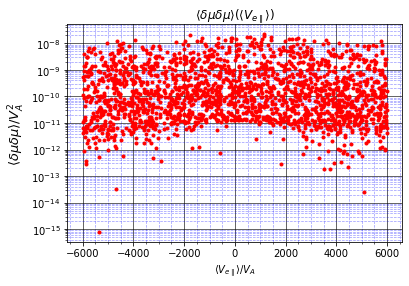

In [15]:
protons_.plot_dmu2_Vx()


Oblique wave $\theta = \pi/4$
---

In [16]:
#Normalization to B0
B0 = [-1,0,0]
E0 = [0,0,0]

norm_B0 = np.linalg.norm(B0)
wc_e = e*norm_B0/(m_e)
wc_p = e*norm_B0/(m_p)

## Normalizing in function to Alfven velocity
V_A = 1

## Perturbation definition
w_wisteler = 5*wc_p
theta = np.pi/4               ## Changing paramether to change resonance condition.
k0 = 2.044*wc_p/V_A
K_ = k0*np.array([np.cos(theta),0,np.sin(theta)])


B_wav = lambda x,t : np.linalg.norm(B0)*1e-4*np.array([0,np.cos(w_wisteler*t+np.dot(K_,x)),np.sin(w_wisteler*t+np.dot(K_,x))])
E_wav = lambda x,t : np.linalg.norm(B0)*1e-4*np.array([0,-np.sin(w_wisteler*t+np.dot(K_,x)),np.cos(w_wisteler*t+np.dot(K_,x))])/c

In [17]:
Ncores = 1              # Number of threads
Npart_eachcore = 10000   # Number of particles per thread
N = 1500                # Number of time steps

## Creating list of classes to thread it
electrons = []
for k in range(Ncores):
    x0, v0 = 1e-6*np.random.rand(Npart_eachcore,3), 2*(np.random.rand(Npart_eachcore,3)-0.5 * np.ones([Npart_eachcore,3]))*6000
    electrons.append(particles(x0*1e-3, v0, m_e, -e))
## Define E,B fields
E = lambda x,t : np.array(E0) + E_wav(x,t)
B = lambda x,t : np.array(B0) + B_wav(x,t)
dt_e = 0.1*wc_e**-1

# List of particles to thread
test_electrons_pusher = []
for k in range(Ncores):
    test_electrons_pusher.append(Boris_pusher(electrons[k],dt_e,E,B,mode = 'Analytical'))

print('\nSimulation of test electrons\n %i Threads\n %i Steps of time so %1.0f cyclotrons periods time simulation\n %i Particles per thread (%i particles in total) \n'%(Ncores,N,N*dt_e*wc_e*2*pi,Npart_eachcore,Ncores*Npart_eachcore))
th_el = []
for k in range(Ncores):
    th_el.append(Thread(target = test_electrons_pusher[k].simulate_opt, args = (N,)))
for thread in th_el:
    thread.start()
for thread in th_el:
    thread.join()

electrons_ = particles_resembled(electrons)


Simulation of test electrons
 1 Threads
 1500 Steps of time so 942 cyclotrons periods time simulation
 10000 Particles per thread (10000 particles in total) 



100%|██████████| 1498/1498 [08:49<00:00,  2.83it/s]


In [18]:
most_res_part = np.where(electrons_.dmu2() == np.max(electrons_.dmu2()))
print('Most resonant electron u_ex = %f'%(electrons_.mean_Vx()[most_res_part]))
### THEORETICAL <U_ex> RESONANT
V_res = (-0*wc_e+w_wisteler)/K_[0]
print('\nTheoretical resonant velocity = %f'%(V_res))

Most resonant electron u_ex = -7.372943

Theoretical resonant velocity = 3.459427


Resonance velocityes = 

[ 5.08508763e+03  3.81468058e+03  2.54427353e+03  1.27386648e+03
  3.45942652e+00 -1.26694763e+03 -2.53735468e+03 -3.80776173e+03
 -5.07816878e+03]


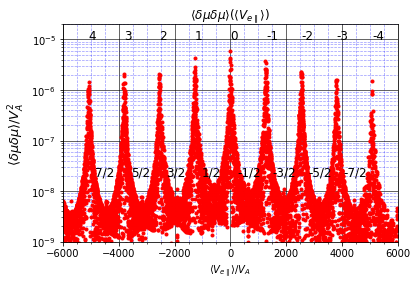

In [21]:
fig = plt.figure()
plt.plot(electrons_.mean_Vx(),electrons_.dmu2(),'.r')
plt.title(r'$\langle\delta\mu\delta\mu\rangle(\langle V_{e\parallel}\rangle)$')
plt.yscale('log')
plt.ylabel(r'$\langle \delta\mu\delta\mu\rangle/V_A^2$ ',size = 13)
plt.xlabel(r'$\langle V_{e\parallel}\rangle/V_A$')
plt.grid(b=True, which='major', color='k',alpha = 0.6,linestyle = '-',linewidth = 1);
plt.minorticks_on()
plt.grid(b=True, which='minor', color='b',alpha = 0.4,linestyle = '--',linewidth = 0.7);
plt.axis([-6000,6000,1e-9,2e-5])
Y =[]
for k in np.arange(-4,5):
    plt.text((-k*wc_e+w_wisteler)/K_[0],1e-5,'%i'%(k),size = 12)
    if k<4 and k>-7:
        plt.text((-(k+0.5)*wc_e+w_wisteler)/K_[0]-400,2e-8,'%i/2'%((k+0.5)*2),size = 12)
print('Resonance velocityes = \n')
print((-(np.arange(-4,5))*wc_e+w_wisteler)/K_[0])

In [81]:
Npart = 1               # Number of particles per thread
N = 100000                # Number of time steps
lisththeta = np.linspace(0,np.pi/2,10)
mu0 = []
mu1 = []
mu_1 = []
for theta in lisththeta:
    ## Creating list of classes to thread it

    ## Define E,B fields
    w_wisteler = 5*wc_p
    k0 = 2.044*wc_p/V_A
    K_ = k0*np.array([np.cos(theta),0,np.sin(theta)])
    
    ## First particle n=0, second n = -1, third n = +1
    x0, v0 = np.array([[0,0,0],[0,0,0],[0,0,0]]), np.array([[(-0*wc_e+w_wisteler)/K_[0],30,0],[(-(-1)*wc_e+w_wisteler)/K_[0],30,0],[(-(+1)*wc_e+w_wisteler)/K_[0],30,0]])
    electrons = particles(x0,v0, m_e, -e)

    B_wav = lambda x,t : np.linalg.norm(B0)*1e-4*np.array([0,np.cos(w_wisteler*t+np.dot(K_,x)),np.sin(w_wisteler*t+np.dot(K_,x))])
    E_wav = lambda x,t : np.linalg.norm(B0)*1e-4*np.array([0,-np.sin(w_wisteler*t+np.dot(K_,x)),np.cos(w_wisteler*t+np.dot(K_,x))])/c
    E = lambda x,t : np.array(E0) + E_wav(x,t)
    B = lambda x,t : np.array(B0) + B_wav(x,t)
    dt_e = 0.1*wc_e**-1

    integrator = Boris_pusher(electrons,dt_e,E,B,mode = 'Analytical')
    print('\nSimulation of test electrons\n\n %i Steps of time so %1.0f cyclotrons periods time simulation\n %i Particles\n'%(N,N*dt_e*wc_e*2*pi,Npart))

    integrator.simulate_opt(N);
    dmu2 = electrons.dmu2()
    mu0.append(dmu2[0])
    mu1.append(dmu2[2])
    mu_1.append(dmu2[1])



Simulation of test electrons

 100000 Steps of time so 62832 cyclotrons periods time simulation
 1 Particles



100%|██████████| 99998/99998 [00:17<00:00, 5749.46it/s]



Simulation of test electrons

 100000 Steps of time so 62832 cyclotrons periods time simulation
 1 Particles



100%|██████████| 99998/99998 [00:18<00:00, 5541.72it/s]



Simulation of test electrons

 100000 Steps of time so 62832 cyclotrons periods time simulation
 1 Particles



100%|██████████| 99998/99998 [00:16<00:00, 5910.03it/s]



Simulation of test electrons

 100000 Steps of time so 62832 cyclotrons periods time simulation
 1 Particles



100%|██████████| 99998/99998 [00:17<00:00, 5860.32it/s]



Simulation of test electrons

 100000 Steps of time so 62832 cyclotrons periods time simulation
 1 Particles



100%|██████████| 99998/99998 [00:16<00:00, 5932.98it/s]



Simulation of test electrons

 100000 Steps of time so 62832 cyclotrons periods time simulation
 1 Particles



100%|██████████| 99998/99998 [00:16<00:00, 5932.89it/s]



Simulation of test electrons

 100000 Steps of time so 62832 cyclotrons periods time simulation
 1 Particles



100%|██████████| 99998/99998 [00:17<00:00, 5770.61it/s]



Simulation of test electrons

 100000 Steps of time so 62832 cyclotrons periods time simulation
 1 Particles



100%|██████████| 99998/99998 [00:17<00:00, 5811.29it/s]



Simulation of test electrons

 100000 Steps of time so 62832 cyclotrons periods time simulation
 1 Particles



100%|██████████| 99998/99998 [00:17<00:00, 5848.82it/s]



Simulation of test electrons

 100000 Steps of time so 62832 cyclotrons periods time simulation
 1 Particles



100%|██████████| 99998/99998 [00:17<00:00, 5730.58it/s]


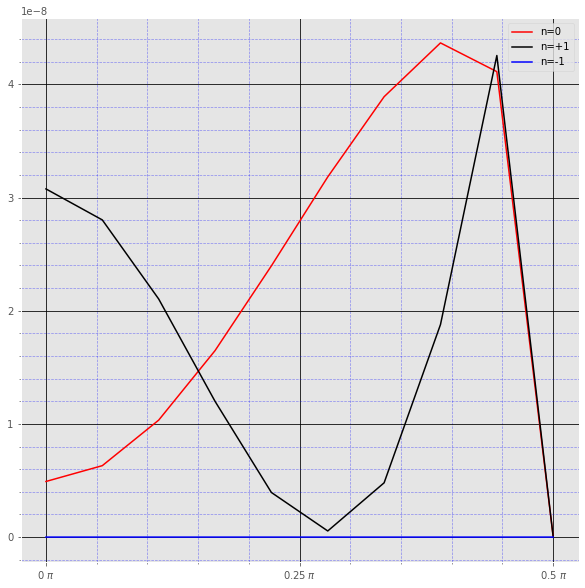

In [83]:
import matplotlib.ticker as tck
import matplotlib.pyplot as plt
import numpy as np

f,ax=plt.subplots(figsize=(10,10))

ax.plot(lisththeta/np.pi,mu0,'r-',label = 'n=0')
ax.plot(lisththeta/np.pi,mu1,'k-',label = 'n=+1')
ax.plot(lisththeta/np.pi,mu_1,'b-',label = 'n=-1')

ax.xaxis.set_major_formatter(tck.FormatStrFormatter('%g $\pi$'))
ax.xaxis.set_major_locator(tck.MultipleLocator(base=1/4))
ax.grid(color = 'k')
ax.minorticks_on()
ax.grid(b=True, which='minor', color='b',alpha = 0.4,linestyle = '--',linewidth = 0.7);
ax.legend()
#ax.set_yscale('log')
plt.show()


[4.9268492969998856e-15,
 4.928604872791967e-15,
 4.9347685000159174e-15,
 4.949017252064161e-15,
 4.977186897844936e-15,
 5.016602264656333e-15,
 5.0470978873863814e-15,
 5.07156269094341e-15,
 5.132790162612285e-15,
 5.186711859962399e-15,
 5.236081499360915e-15,
 5.321648209874322e-15,
 5.3807329089651514e-15,
 5.478115426019729e-15,
 5.569842447287856e-15,
 5.6572084109359895e-15,
 5.789765943416684e-15,
 5.911041935060342e-15,
 6.02605724764984e-15,
 6.167198824311718e-15,
 6.334845780936474e-15,
 6.516181478026843e-15,
 6.706818447763535e-15,
 6.909657414055903e-15,
 7.127779436007579e-15,
 7.364053055074817e-15,
 7.617847954055678e-15,
 7.888218623351231e-15,
 8.174796564173989e-15,
 8.48653394328935e-15,
 8.84456292023815e-15,
 9.259850430057006e-15,
 9.702484911852335e-15,
 1.0133145037260627e-14,
 1.0611132113295461e-14,
 1.1212849531243723e-14,
 1.1827637805731147e-14,
 1.243293068020872e-14,
 1.3227935893677687e-14,
 1.4045257663060179e-14,
 1.4877608429045742e-14,
 1.59844